<a href="https://colab.research.google.com/github/Himanshu069/trictrl/blob/sim/NMPC-Imitation/(Q_loss)Collocation_NN_controller.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch pandas scikit-learn
!pip install matplotlib
!pip install do-mpc
!pip install numpy
!pip install casadi
!pip install pandas
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset


In [ ]:
# Load CSV
df = pd.read_csv('nmpc_dataset[omega0andvarying].csv')
# df2 = pd.read_csv('nmpc_dataset[triangle-stabilization].csv')

# df = pd.concat([df1, df2], ignore_index=True)
df = df.sort_values(['time']).reset_index(drop=True)
df['theta_next'] = df['theta'].shift(-1)
df['dtheta_next'] = df['dtheta'].shift(-1)
df['dphi_next'] = df['dphi'].shift(-1)
df['dt'] = df['time'].diff().shift(-1)
df = df.dropna()


X = df[['theta', 'dtheta']].values
# X_next = df[['theta_next', 'dtheta_next', 'dphi_next']].values
dt_array = df['dt'].values
y = df['u'].values.reshape(-1, 1)

# Convert to float32 for PyTorch
X = X.astype(np.float32)
# X_next = X_next.astype(np.float32)
dt_array = dt_array.astype(np.float32)
y = y.astype(np.float32)

# Split: 60% train, 20% validation, 20% test
indices = np.arange(len(X))
train_idx, temp_idx = train_test_split(indices, test_size=0.4, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val = X[val_idx], y[val_idx]
X_test, y_test = X[test_idx], y[test_idx]
# X_train, X_next_train, dt_train, y_train = X[train_idx], X_next[train_idx], dt_array[train_idx], y[train_idx]
# X_val, X_next_val, dt_val, y_val = X[val_idx], X_next[val_idx], dt_array[val_idx], y[val_idx]
# X_test, X_next_test, dt_test, y_test = X[test_idx], X_next[test_idx], dt_array[test_idx], y[test_idx]

mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
std[std == 0] = 1e-8

X_train = (X_train - mean) / std
X_val = (X_val - mean) / std
X_test = (X_test - mean) / std

# X_train = np.vstack([
#     X_train,
#     X_train * np.array([-1, -1, -1], dtype=np.float32)  # ensure float32
# ]).astype(np.float32)

# y_train = np.vstack([
#     y_train,
#     -y_train
# ]).astype(np.float32)
# X_next_train = (X_next_train - mean) / std
# X_next_val = (X_next_val - mean) / std
# X_next_test = (X_next_test - mean) / std

train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_dataset = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
# train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(X_next_train), torch.from_numpy(dt_train), torch.from_numpy(y_train))
# val_dataset = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(X_next_val), torch.from_numpy(dt_val), torch.from_numpy(y_val))
# test_dataset = TensorDataset(torch.from_numpy(X_test),torch.from_numpy(X_next_test), torch.from_numpy(dt_test), torch.from_numpy(y_test))

# DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

FileNotFoundError: [Errno 2] No such file or directory: 'nmpc_dataset[omega0andvarying].csv'

In [ ]:
class NMPCNet(nn.Module):
    def __init__(self, input_dim=2, hidden1=64, hidden2=64, output_dim=1):
        super(NMPCNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, output_dim)
        )

    def forward(self, x):
        return self.model(x)

# Initialize network
model = NMPCNet()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
# M = 0.01825
# mb = 0.286
# mw = 0.079
# Iw = 0.000040394
# Ib = 0.0004370975
# lb = 0.05
# lw = 0.05
# g = 9.81
# I = Ib + mb*lb*lb + mw*lw*lw
# def dynamics_continuous(X_norm, u):
#     """
#     Continuous-time dynamics: dX/dt = f(X, u)
#     X_norm: normalized [theta, dtheta, dphi]
#     u: control torque
#     Returns: normalized derivatives [dtheta, ddtheta, ddphi]
#     """
#     # Denormalize
#     X = X_norm * torch.tensor(std, dtype=torch.float32) + torch.tensor(mean, dtype=torch.float32)

#     theta = X[:, 0]
#     dtheta = X[:, 1]
#     dphi = X[:, 2]

#     # Equations of motion
#     ddtheta = (M*g*torch.sin(theta) - u.squeeze()) / I
#     ddphi = u.squeeze()/Iw - ddtheta

#     # Stack derivatives
#     X_dot = torch.stack([dtheta, ddtheta, ddphi], dim=1)

#     # Normalize
#     X_dot_norm = X_dot / torch.tensor(std, dtype=torch.float32)
#     return X_dot_norm

# def rk4_step(X_norm, u, dt):
#     """RK4 integration"""
#     k1 = dynamics_continuous(X_norm, u)
#     k2 = dynamics_continuous(X_norm + dt/2 * k1, u)
#     k3 = dynamics_continuous(X_norm + dt/2 * k2, u)
#     k4 = dynamics_continuous(X_norm + dt * k3, u)

#     X_next_norm = X_norm + dt/6 * (k1 + 2*k2 + 2*k3 + k4)
#     return X_next_norm

In [ ]:

import numpy as np
import pandas as pd
import sys
from casadi import *
import do_mpc
import matplotlib.pyplot as plt

# ----------------------------
# Model setup
# ----------------------------
model_type = 'continuous'  # 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)
# System parameters
M = 0.01825
mb = 0.286
mw = 0.079
Iw = 0.000040394
Ib = 0.0004370975
lb = 0.05
lw = 0.05
g = 9.81
I = Ib + mb*lb*lb + mw*lw*lw

# States
theta = model.set_variable('_x','theta')
phi = model.set_variable('_x','phi')
dtheta = model.set_variable('_x','dtheta')
dphi = model.set_variable('_x','dphi')

# Control
u = model.set_variable('_u','torque')

# Algebraic variables
ddtheta = model.set_variable('_z', 'ddtheta')
ddphi = model.set_variable('_z', 'ddphi')

# RHS
model.set_rhs('theta', dtheta)
model.set_rhs('phi', dphi)
model.set_rhs('dtheta', ddtheta)
model.set_rhs('dphi', ddphi)

# Euler-Lagrange equations
euler_lagrange = vertcat(
    (I+Iw)*ddtheta + Iw*ddphi - M*g*sin(theta),
    Iw*(ddtheta + ddphi) - u
)
model.set_alg('euler_lagrange', euler_lagrange)
model.setup()

mpc = do_mpc.controller.MPC(model)

setup_mpc = {
    'n_horizon': 50,
    'n_robust': 0,
    'open_loop': 0,
    't_step': 0.04,
    'state_discretization': 'collocation',
    'collocation_type': 'radau',
    'collocation_deg': 6,
    'collocation_ni': 1,
    'store_full_solution': True,
    'nlpsol_opts': {
        'ipopt.linear_solver': 'mumps',
        # 'ipopt.print_level': 0,  # suppress IPOPT iteration logs
        # 'print_time': 0,         # suppress IPOPT timing summary
        # 'ipopt.sb': 'yes',       # suppress IPOPT banner
        # 'verbose': False       # suppress CasADi-level output
    }
}
mpc.set_param(**setup_mpc)

# Objective
Q1 = 1000
Q2 = 5
Q3 = 1
R = 1
omega_s = 0
mterm = Q1*model.x['theta']**2 + Q2*model.x['dtheta']**2 + Q3*(model.x['dphi']-omega_s)**2
lterm = Q1*model.x['theta']**2 + Q2*model.x['dtheta']**2 + Q3*(model.x['dphi']-omega_s)**2
mpc.set_objective(mterm=mterm, lterm=lterm)
mpc.set_rterm(torque= R)

mpc.bounds['lower','_u','torque'] = -0.5
mpc.bounds['upper','_u','torque'] = 0.5
# mpc.bounds['lower','_x','dphi'] = -1000
# mpc.bounds['upper','_x','dphi'] = 1000


mpc.setup()

# ----------------------------
# Estimator and simulator
# ----------------------------
estimator = do_mpc.estimator.StateFeedback(model)
simulator = do_mpc.simulator.Simulator(model)
params_simulator = {
    'integration_tool': 'idas',
    'abstol': 1e-8,
    'reltol': 1e-8,
    't_step': 0.04
}
simulator.set_param(**params_simulator)
simulator.setup()
# simulator.x0['theta'] = 3.14

# x0 = simulator.x0.cat.full()

# mpc.x0 = x0
# estimator.x0 = x0

# mpc.set_initial_guess()
mpc.settings.store_full_solution = True
mpc_graphics = do_mpc.graphics.Graphics(mpc.data)
mpc.settings.store_lagr_multiplier = True


/usr/local/lib/python3.12/dist-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/usr/local/lib/python3.12/dist-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


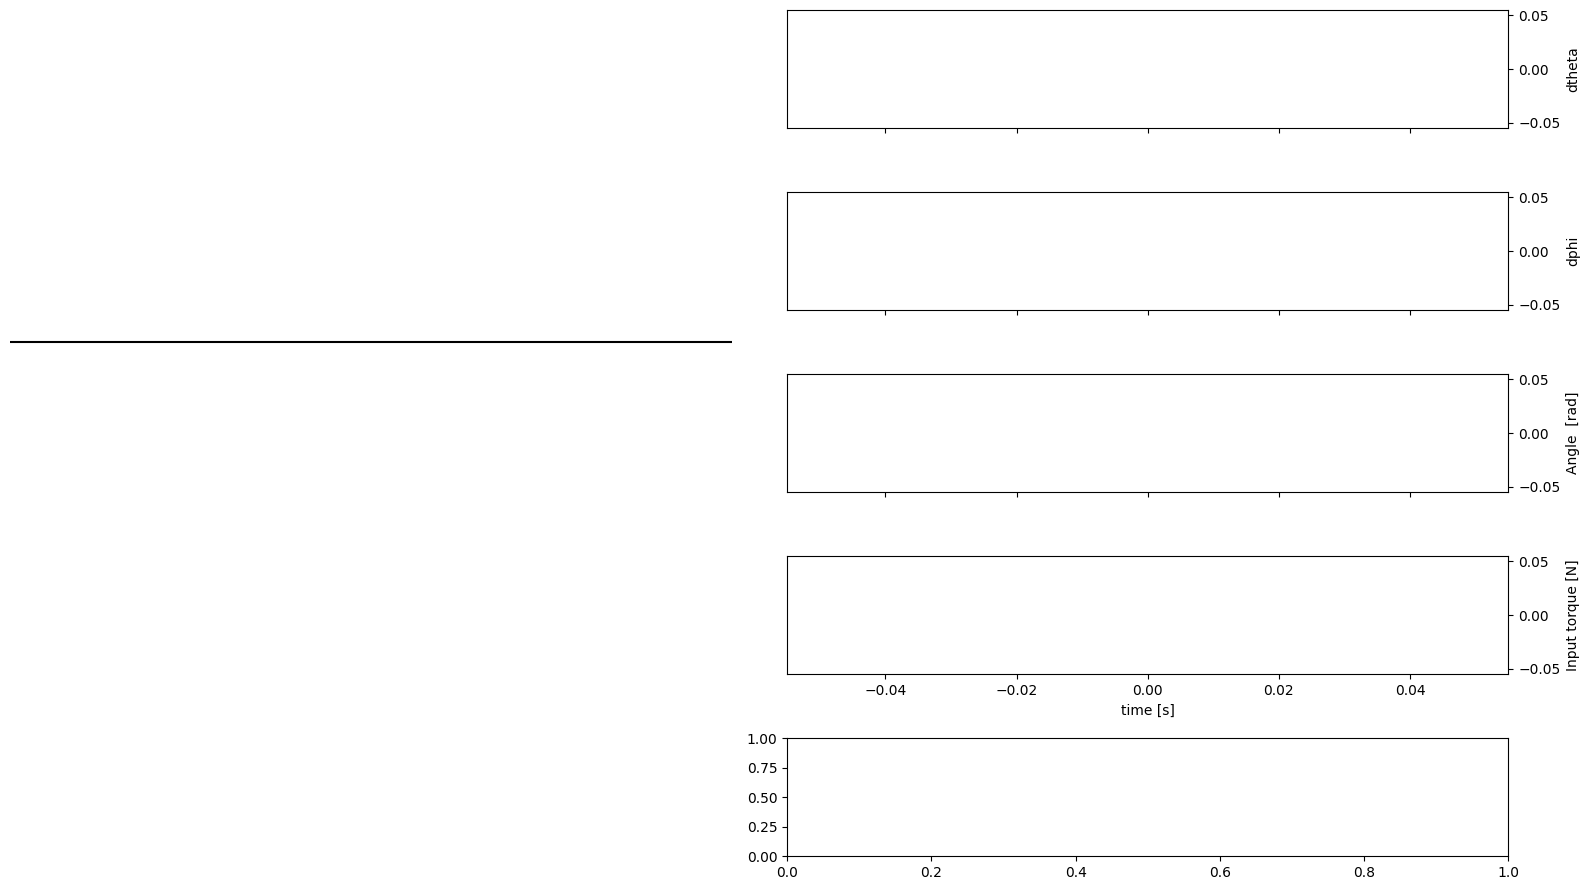

In [ ]:
fig = plt.figure(figsize=(16,9));

ax1 = plt.subplot2grid((5, 2), (0, 0), rowspan=4)
ax2 = plt.subplot2grid((5, 2), (0, 1))
ax3 = plt.subplot2grid((5, 2), (1, 1))
ax4 = plt.subplot2grid((5, 2), (2, 1))
ax5 = plt.subplot2grid((5, 2), (3, 1))
ax6 = plt.subplot2grid((5, 2), (4, 1))

ax2.set_ylabel('dtheta')
ax3.set_ylabel('dphi')
ax4.set_ylabel('Angle  [rad]')
ax5.set_ylabel('Input torque [N]')

# Axis on the right.
for ax in [ax2, ax3, ax4, ax5]:
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    if ax != ax5:
        ax.xaxis.set_ticklabels([])

ax5.set_xlabel('time [s]')

mpc_graphics.add_line(var_type='_x', var_name='dtheta', axis=ax2)
mpc_graphics.add_line(var_type='_x', var_name='dphi', axis=ax3)
mpc_graphics.add_line(var_type='_x', var_name='theta', axis=ax4)
mpc_graphics.add_line(var_type='_u', var_name='torque', axis=ax5)

ax1.axhline(0,color='black')

bar1 = ax1.plot([],[], '-o', linewidth=5, markersize=10)
bar2 = ax1.plot([],[], '-o', linewidth=5, markersize=10)

ax1.set_xlim(-1.8,1.8)
ax1.set_ylim(-1.2,1.2)
ax1.set_axis_off()

fig.align_ylabels()
fig.tight_layout()

/usr/local/lib/python3.12/dist-packages/do_mpc/controller/_mpc.py:1004: UserWarning: Intial guess for the MPC was not set. The solver call is likely to fail.
  warnings.warn('Intial guess for the MPC was not set. The solver call is likely to fail.')



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    12504
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      552

Total number of variables............................:     2382
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       50
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2304
Total number of inequality c

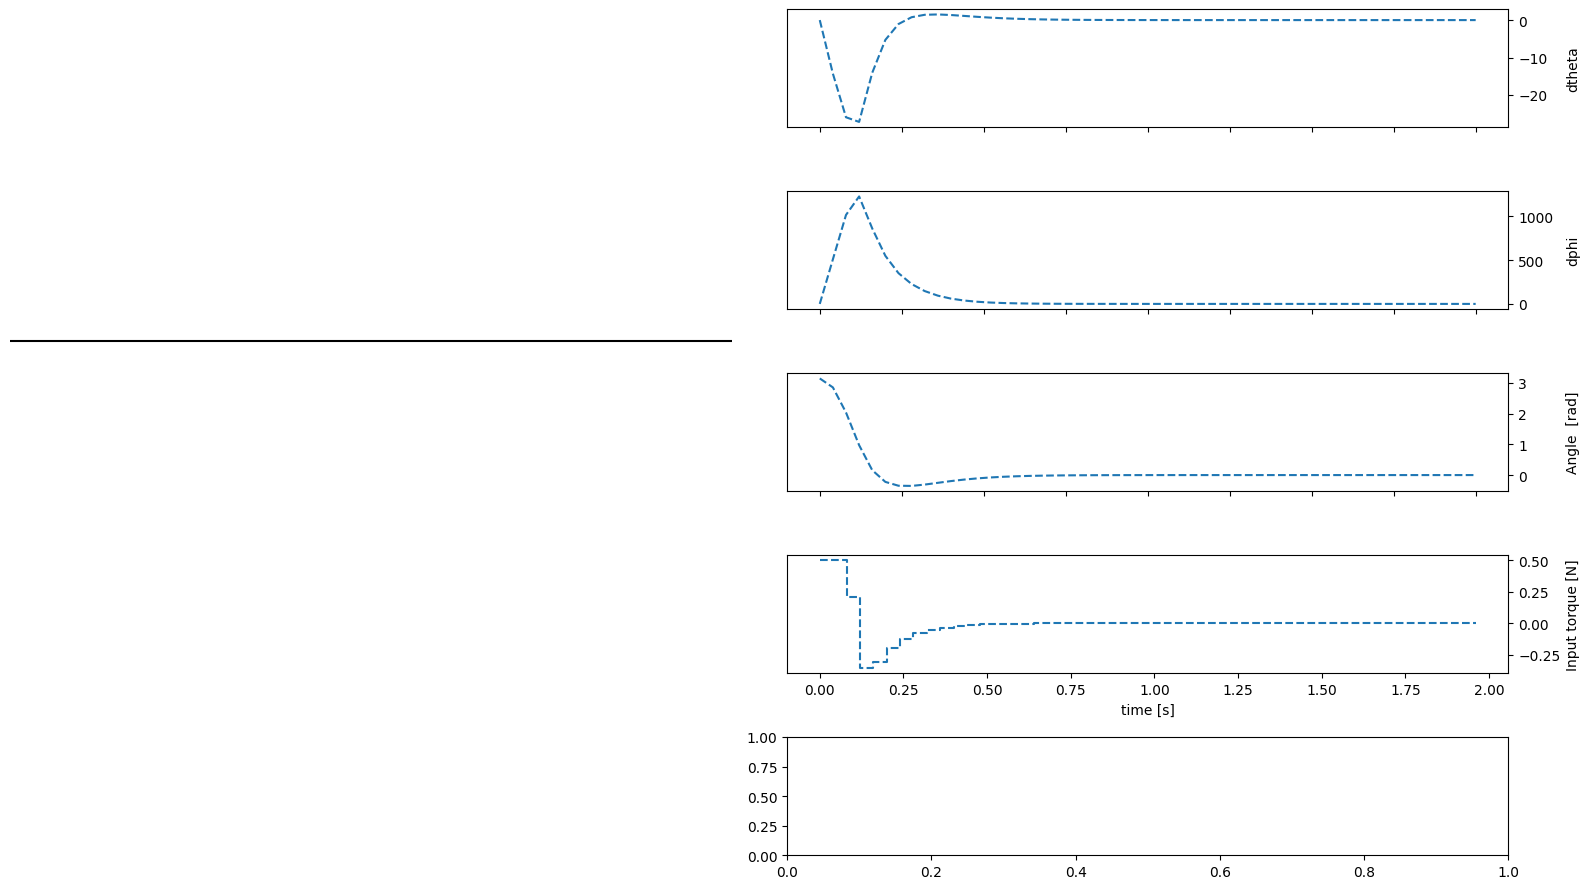

In [ ]:
from casadi import Function, gradient
def evaluate_mpc(x0, u_guess=None):

    # eps = 1e-3
    # mpc.bounds['lower','_u','torque'] = u_guess
    # mpc.bounds['upper','_u','torque'] = u_guess
    # mpc.u0['torque', 0] = u_guess
# _u_0_0_torque
    # Set initial guess for MPC solver
    # if u_guess is None:
    #     # If no guess provided, use zeros for entire horizon
    #     u_guess_full = np.zeros((50, 1))
    # else:
    #     # Convert single control input to full horizon guess
    #     u_guess = np.array(u_guess).reshape(-1, 1)  # ensure column vector
    #     # Use the provided guess for first step, zeros for rest
    #     u_guess_full = np.vstack([
    #         u_guess.T,  # first control
    #         np.zeros((50 - 1, 1))  # zeros for remaining
    #     ])


    # Set initial guess for MPC solver


    simulator.x0 = x0
    mpc.x0 = x0
    estimator.x0 = x0
    mpc.u0 = u_guess
    mpc.reset_history()

    u0 = mpc.make_step(x0)
    nlp = mpc.nlp  # CasADi NLP solver object
    xu_opt = mpc.opt_x_num

    lm = mpc.lam_x_num
    # print("lambda", lm)

    # print("Total constraints:", lm.shape)
    # print("Constraint names:", mpc.opt_x_num.keys())
    # print("NLP",nlp['x'].shape,nlp['x'].numel())

    # # Create proper NLP decision variable by concatenating state and control trajectories
    # for i in range(nlp['x'].numel()):
    #   print(nlp['x'][i])

    cost_fun = Function('cost_fun', [nlp['x'], nlp['p']], [nlp['f']])
    # print("lambda multiplier", lm[-50])
    p_val = np.zeros(nlp['p'].shape)
    print("xu_opt shape:", xu_opt.shape)
    print("p_val shape:", p_val.shape)
    # if nlp['p'].numel() > 0:
    #     # usually initial state is used as parameter
    #     p_val = np.array(x0).reshape(nlp['p'].shape)
    cost_value = float(cost_fun(xu_opt, p_val))
    grad_value_u = lm[-50]

    return u0, cost_value, grad_value_u

# -------------------------
# Example usage
# -------------------------
x0_example = np.array([[3.14, 0, 0, 0]]).T
u0_guess_example = np.array([0.4])  # Single control input guess

u0_action, cost_val, grad_val = evaluate_mpc(x0_example, u0_guess_example)
print("First control u0:", u0_action)
print("Cost function value:", cost_val)
print("Gradient:", grad_val)

mpc_graphics.plot_predictions()
mpc_graphics.reset_axes()

fig


In [ ]:
from torch import autograd


class QMpc(autograd.Function):
    @staticmethod
    def forward(
        ctx,
        x: torch.Tensor,
        u: torch.Tensor,
        ocp_solver: MPCBaseClass,
        qp_approx: bool = False,
        lin_vec: torch.Tensor = None,
    ):
        device, dtype = x.device, x.dtype

        x_cpu = x.cpu()
        u_cpu = u.cpu()
        ctx.save_for_backward(x_cpu, u_cpu)

        x_np = x_cpu.detach().numpy().astype("float64")
        u_np = u_cpu.detach().numpy().astype("float64")
        if qp_approx:
            (
                Q_val_batch,
                grad_u_batch,
                grad_x_batch,
            ) = ocp_solver.solve_parametric_quadratic_ocp_batch(x_np, u_np, lin_vec)
        else:
            (
                u0,
                Q_val_batch,
                grad_u_batch,
            ) = evaluate_mpc(x_np, u_np)
        ctx.grad_u_batch = grad_u_batch
        # ctx.grad_x_batch = grad_x_batch

        return torch.tensor(np.nanmean(Q_val_batch), device=device, dtype=dtype)

    @staticmethod
    def backward(ctx, grad_output):
        device, dtype = grad_output.device, grad_output.dtype

        grad_u_batch = torch.tensor(ctx.grad_u_batch, device=device, dtype=dtype)
        # grad_x_batch = torch.tensor(ctx.grad_x_batch, device=device, dtype=dtype)

        return None, grad_u_batch, None, None, None

In [ ]:

# lambda_physics = 0.01
# lambda_theta = 0.1
# theta_thresh = 0.35
# Early stopping parameters
max_epochs = 1000          # Maximum epochs, safety limit
patience = 40              # Stop if no improvement in 'patience' epochs
min_delta = 1e-6           # Minimum change to qualify as improvement

best_val_loss = float('inf')
epochs_no_improve = 0
train_losses, val_losses = [], []

for epoch in range(max_epochs):
    # --- Training ---
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        u_pred = model(X_batch)
        loss_supervised = criterion(u_pred, y_batch)

        # X_next_pred = torch.zeros_like(X_next_batch)

        # for i in range(len(X_batch)):
        #     X_next_pred[i] = rk4_step(X_batch[i:i+1], u_pred[i:i+1], dt_batch[i].item())

        # theta_next = X_next_pred[:, 0] * std[0] + mean[0]
        # mask = (theta_next.abs() < theta_thresh).float()
        # loss_theta = lambda_theta * torch.mean(mask * theta_next**2)

        # loss_physics = criterion(X_next_pred, X_next_batch)

        # Total loss
        loss = loss_supervised
        # + lambda_physics * loss_physics + loss_theta

        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    train_loss /= len(train_loader.dataset)

    # --- Validation ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            u_pred = model(X_batch)
            loss_supervised = criterion(u_pred, y_batch)

            # X_next_pred = torch.zeros_like(X_next_batch)
            # for i in range(len(X_batch)):
            #     X_next_pred[i] = rk4_step(X_batch[i:i+1], u_pred[i:i+1], dt_batch[i].item())

            # theta_next = X_next_pred[:, 0] * std[0] + mean[0]
            # mask = (theta_next.abs() < theta_thresh).float()
            # loss_theta = lambda_theta * torch.mean(mask * theta_next**2)

            # loss_physics = criterion(X_next_pred, X_next_batch)

            loss = loss_supervised
            # + lambda_physics * loss_physics + loss_theta
            val_loss += loss.item() * X_batch.size(0)
    val_loss /= len(val_loader.dataset)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch [{epoch+1}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

    if best_val_loss - val_loss > min_delta:
        best_val_loss = val_loss
        epochs_no_improve = 0
                # Save checkpoint when improvement occurs
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'train_loss': train_loss
        }
        torch.save(checkpoint, 'best_model_checkpoint.pth')
        print("Validation loss improved — checkpoint saved.")
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f'Validation loss did not improve for {patience} epochs. Stopping early.')
        break

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
model.eval()
y_true_all, y_pred_all = [], []
test_loss = 0.0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        u_pred = model(X_batch)
        loss_supervised = criterion(u_pred, y_batch)

        # X_next_pred = torch.zeros_like(X_next_batch)
        # for i in range(len(X_batch)):
        #     X_next_pred[i] = rk4_step(X_batch[i:i+1], u_pred[i:i+1], dt_batch[i].item())

        # theta_next = X_next_pred[:, 0] * std[0] + mean[0]
        # mask = (theta_next.abs() < theta_thresh).float()
        # loss_theta = lambda_theta * torch.mean(mask * theta_next**2)

        # loss_physics = criterion(X_next_pred, X_next_batch)
        y_true_all.append(y_batch.numpy())
        y_pred_all.append(u_pred.numpy())
        loss = loss_supervised
        # + lambda_physics * loss_physics + loss_theta
        test_loss += loss.item() * X_batch.size(0)
test_loss /= len(test_loader.dataset)
print(f'Test Loss: {test_loss:.6f}')
y_true_all = np.vstack(y_true_all)
y_pred_all = np.vstack(y_pred_all)

mse = mean_squared_error(y_true_all, y_pred_all)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true_all, y_pred_all)
r2 = r2_score(y_true_all, y_pred_all)

print("\n===== PERFORMANCE SUMMARY =====")
print(f"Training Loss (Final): {train_losses[-1]:.6f}")
print(f"Validation Loss (Best): {best_val_loss:.6f}")
print(f"Test Loss (MSE): {mse:.6f}")
print(f"Test RMSE: {rmse:.6f}")
print(f"Test MAE: {mae:.6f}")
print(f"Test R² Score: {r2:.6f}")

# Optional correlation
corr = np.corrcoef(y_true_all.squeeze(), y_pred_all.squeeze())[0, 1]
print(f"Correlation between predicted and true control: {corr:.4f}")

model_path = 'nmpc_nn_controller.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'best_val_loss': best_val_loss,
    'mean': mean,
    'std': std,
}, model_path)

print(f"Model saved to {model_path}")
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import torch
import numpy as np
from torch import nn

# --- Load checkpoint ---
checkpoint = torch.load('nmpc_nn_controller.pth', map_location='cpu',weights_only=False)
state_dict = checkpoint['model_state_dict']

# --- Load weights into model ---
model = NMPCNet()
model.load_state_dict(state_dict)
model.eval()
# --- Extract parameters into NumPy ---
weights = {name: param.detach().numpy() for name, param in model.named_parameters()}
weights['mean'] = mean.astype(np.float32)
weights['std'] = std.astype(np.float32)

# --- Save them as .npz ---
np.savez("nmpc_nn_controller(tv-1%).npz", **weights)
print("Converted to NumPy file: nmpc_nn_controller-BC.npz")